In [1]:
# %load_ext autoreload
# %autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from pyPSFstack.pupils.sources import DipoleInterfaceSource
from pyPSFstack.pupils.windows import SEO
from pyPSFstack.pupils.aberrations import UnitaryAberrations
from pyPSFstack.core import PSFStack, trim_stack
from pyPSFstack.diversities import ZDiversity, PDiversity
from pyPSFstack.cost_functions import CostGaussian

from pyPSFstack_torch.psf_modules import IncoherentPSF#,ScalarPhaseAberrations,\
    # ScalarPSF

In [2]:
from pyPSFstack_torch.psf_modules import AberratedIncoherentPSF

In [3]:

from pyPSFstack_torch.sources import DipoleInterfaceSource
from pyPSFstack_torch.windows import SEO
from pyPSFstack_torch.aberrations import UnitaryPolarizationAberrations
from pyPSFstack_torch.diversities import ZDiversity, PDiversity
from pyPSFstack_torch.functions import polar_mesh, xy_mesh
from pyPSFstack_torch.functions import crop_center

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
numerical_aperture = 1.49
magnification = 100
ni = 1.33
nf = 1.518
cam_pixel_size = 6500
distance_coverslip = 30
wavelength = 525
aperture_size=numerical_aperture / nf
computation_size=wavelength*magnification/(cam_pixel_size*nf)
N_pts = 128

zi = -300; zf = 300; z_step = 100
z_list = torch.arange(zi,zf+z_step,z_step) / wavelength

angle_i = 0; angle_f = np.pi/2; angle_step = np.pi/4
angle_list=np.arange(angle_i,angle_f+angle_step,angle_step)

In [6]:
source = DipoleInterfaceSource(aperture_size=aperture_size,
 computation_size=computation_size, 
                 N_pts=128, ni=1.33, nf=1.518, delta=0.1)
seo = SEO(aperture_size=aperture_size,
 computation_size=computation_size, 
                 N_pts=128)
aberrations = UnitaryPolarizationAberrations(aperture_size=aperture_size, computation_size=computation_size, 
                 N_pts=128, jmax=[15]*5, index_convention='fringe')
zdiv = ZDiversity(aperture_size=aperture_size,
 computation_size=computation_size, 
                 N_pts=128)

/opt/anaconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/rodrigo/Documents/Research/CHIDO/pyPSFstack/pyPSFstack_torch/sources.py:65: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/Copy.cpp:244.)
  aperture = self.ur2.type(torch.float) <= aperture_size**2


In [7]:
model_measured = IncoherentPSF(
                 pol_analyzer='quarter2pol',
                 angle_list=np.arange(angle_i,angle_f+angle_step,angle_step),
                 aperture_size=numerical_aperture / nf, 
                 computation_size=wavelength*magnification/(cam_pixel_size*nf), 
                 N_pts=128, 
                 ni=1.33, 
                 nf=1.518, 
                 delta=0.1,
                 c=1.24*np.pi,
                 jmax=[15]*5, 
                 index_convention='fringe'
                 )

In [8]:
with torch.no_grad():
    model_measured.eval()
    data = model_measured(z_list, 30)

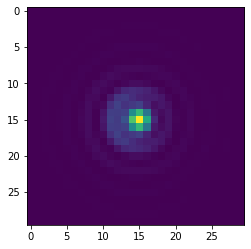

In [9]:
plt.imshow(data[...,2,0])

In [10]:
model_retrieved = AberratedIncoherentPSF(
                 pol_analyzer='quarter2pol',
                 angle_list=np.arange(angle_i,angle_f+angle_step,angle_step),
                 aperture_size=numerical_aperture / nf, 
                 computation_size=wavelength*magnification/(cam_pixel_size*nf), 
                 N_pts=128, 
                 ni=1.33, 
                 nf=1.518, 
                 delta=0.1,
                 jmax=[15]*5, 
                 index_convention='fringe'
                 )

In [11]:
lr = 1e-2
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
# optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(
    model_retrieved.parameters(), 
    lr=lr
)
loss_evol =[]
for epoch in range(n_epochs):
    # What is this?!?
    model_retrieved.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model_retrieved(z_list, 30)
    
    loss = loss_fn(data, yhat)
    loss_evol += [loss.item()]
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    if epoch%100==0:
        print(epoch)
    


0
100
200
300
400
500
600
700
800
900


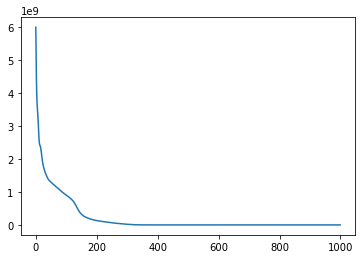

In [20]:
plt.plot((loss_evol))

In [34]:
yhat.shape

torch.Size([30, 30, 7, 6])

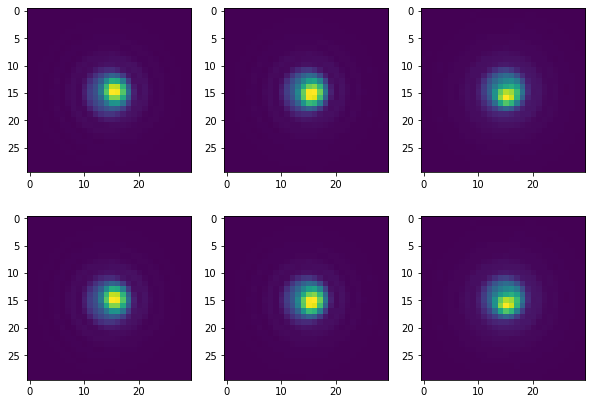

In [13]:
pdiv_ind = 1
zdiv_mid_ind = int((zf-zi)/z_step//2)
fig, ax = plt.subplots(2,3,figsize=(10,7))
for ind in range(3):
    ax[0,ind].imshow(data[...,zdiv_mid_ind-1+ind,pdiv_ind])
    ax[1,ind].imshow(yhat.detach().numpy()[...,zdiv_mid_ind-1+ind,pdiv_ind])

In [14]:
ux, uy = xy_mesh(2, computation_size/N_pts)
N_p = ux.shape[0]
dummy_input = torch.zeros((N_p,N_p,2,2), dtype=torch.cfloat)
dummy_input[...,0,0]=1
dummy_input[...,1,1]=1

In [15]:
with torch.no_grad():
    model_retrieved.aberrations.eval()
    pupil_ret = model_retrieved.aberrations(dummy_input)
with torch.no_grad():
    model_measured.aberrations.eval()
    pupil = model_measured.window(dummy_input)

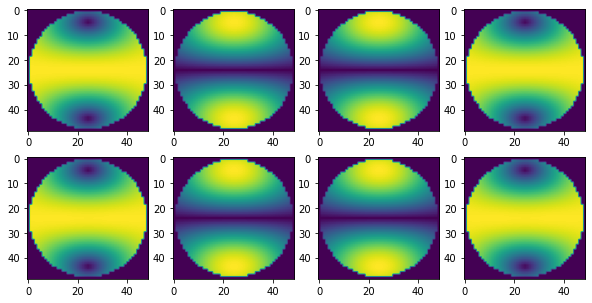

In [16]:
fig, ax = plt.subplots(2,4,figsize=(10,5))
for inx in range(2):
    for iny in range(2):
        ax[0,inx+2*iny].imshow(np.abs(pupil[...,inx,iny]))
        ax[1,inx+2*iny].imshow(np.abs(pupil_ret[...,inx,iny]))

In [17]:
model_retrieved.state_dict()

OrderedDict([('source.delta', tensor(0.0993)),
             ('aberrations.c_q',
              tensor([[ 2.5587e-01, -8.4264e-05,  5.6779e-06, -3.8320e-01,  5.3332e-05,
                       -1.0736e-06,  7.0082e-05,  1.1852e-05,  3.4616e-02, -1.4492e-05,
                       -1.8886e-07,  2.5309e-05, -1.3020e-06, -6.1233e-06,  1.6087e-05],
                      [-3.5198e-06,  1.7422e-06, -8.7256e-01, -9.7723e-07,  1.9497e-06,
                       -8.8958e-05, -2.1919e-06,  1.5571e-01, -7.3232e-07, -1.6692e-06,
                        5.7440e-05,  7.8040e-07,  1.3176e-04, -1.0058e-06, -7.0998e-03],
                      [ 1.8859e-06, -9.5571e-07,  1.6952e-06,  1.7348e-06,  4.7872e-07,
                        4.9139e-05, -3.0582e-07, -1.1723e-04, -1.7274e-06,  2.1792e-06,
                       -2.2916e-05,  1.0041e-07, -1.1935e-05, -2.2135e-06,  1.1837e-04],
                      [ 7.9040e-05, -8.7267e-01, -4.2953e-07,  9.6855e-06, -9.0325e-05,
                       -2.8184e-06,  

In [18]:
model_retrieved.state_dict()

OrderedDict([('source.delta', tensor(0.0993)),
             ('aberrations.c_q',
              tensor([[ 2.5587e-01, -8.4264e-05,  5.6779e-06, -3.8320e-01,  5.3332e-05,
                       -1.0736e-06,  7.0082e-05,  1.1852e-05,  3.4616e-02, -1.4492e-05,
                       -1.8886e-07,  2.5309e-05, -1.3020e-06, -6.1233e-06,  1.6087e-05],
                      [-3.5198e-06,  1.7422e-06, -8.7256e-01, -9.7723e-07,  1.9497e-06,
                       -8.8958e-05, -2.1919e-06,  1.5571e-01, -7.3232e-07, -1.6692e-06,
                        5.7440e-05,  7.8040e-07,  1.3176e-04, -1.0058e-06, -7.0998e-03],
                      [ 1.8859e-06, -9.5571e-07,  1.6952e-06,  1.7348e-06,  4.7872e-07,
                        4.9139e-05, -3.0582e-07, -1.1723e-04, -1.7274e-06,  2.1792e-06,
                       -2.2916e-05,  1.0041e-07, -1.1935e-05, -2.2135e-06,  1.1837e-04],
                      [ 7.9040e-05, -8.7267e-01, -4.2953e-07,  9.6855e-06, -9.0325e-05,
                       -2.8184e-06,  

In [ ]:
print(model_retrieved.state_dict())